# Advanced Cyberbullying Detection

In [1]:
# Imports
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

# Warnings
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# GPU Availability
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


## Loading Dataset

**Load Dataset**:

In [3]:
DATA_DIR = Path("../dataset")

# Check available datasets
csv_paths = sorted(DATA_DIR.glob("*.csv"))

print("Found CSVs:", len(csv_paths))
for f in csv_paths:
    print(f.name)

Found CSVs: 9
aggression_parsed_dataset.csv
attack_parsed_dataset.csv
cyberbullying_tweets.csv
kaggle_parsed_dataset.csv
toxicity_parsed_dataset.csv
twitter_parsed_dataset.csv
twitter_racism_parsed_dataset.csv
twitter_sexism_parsed_dataset.csv
youtube_parsed_dataset.csv


In [4]:
# Read dfs
dfs = {}

for f in csv_paths:
    path = DATA_DIR / f
    dfs[f] = pd.read_csv(path)
    print(f"{f}: shape={dfs[f].shape}")

..\dataset\aggression_parsed_dataset.csv: shape=(115864, 5)
..\dataset\attack_parsed_dataset.csv: shape=(115864, 5)
..\dataset\cyberbullying_tweets.csv: shape=(47692, 2)
..\dataset\kaggle_parsed_dataset.csv: shape=(8799, 4)
..\dataset\toxicity_parsed_dataset.csv: shape=(159686, 5)
..\dataset\twitter_parsed_dataset.csv: shape=(16851, 5)
..\dataset\twitter_racism_parsed_dataset.csv: shape=(13471, 5)
..\dataset\twitter_sexism_parsed_dataset.csv: shape=(14881, 5)
..\dataset\youtube_parsed_dataset.csv: shape=(3464, 10)


In [5]:
# Check Columns
for fname, df in dfs.items():
    print(f"{fname}, Columns: {df.columns}")

..\dataset\aggression_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\attack_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\cyberbullying_tweets.csv, Columns: Index(['tweet_text', 'cyberbullying_type'], dtype='str')
..\dataset\kaggle_parsed_dataset.csv, Columns: Index(['index', 'oh_label', 'Date', 'Text'], dtype='str')
..\dataset\toxicity_parsed_dataset.csv, Columns: Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='str')
..\dataset\twitter_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\twitter_racism_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\twitter_sexism_parsed_dataset.csv, Columns: Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='str')
..\dataset\youtube_parsed_dataset.csv, Colu

**Clean Dataset**:

In [6]:
# Drop the unwanted columns and rename the column names
cleaned_dfs = {}

for fname, df in dfs.items():
    # Get the text column
    if "tweet_text" in df.columns:
        text_col = "tweet_text"
    else:
        text_col = "Text"

    # Get the label column
    if "cyberbullying_type" in df.columns:
        label_col = "cyberbullying_type"
    else:
        label_col = "oh_label"

    # Keep the columns and rename
    out = df[[text_col, label_col]].copy()
    out = out.rename(columns={text_col: "text", label_col: "is_cyberbullying"})

    # Assign the cleaned dfs
    cleaned_dfs[fname] = out

In [7]:
# Check Columns
for fname, df in cleaned_dfs.items():
    print(f"{fname}, Columns: {df.columns}")

..\dataset\aggression_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\attack_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\cyberbullying_tweets.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\kaggle_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\toxicity_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_racism_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\twitter_sexism_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')
..\dataset\youtube_parsed_dataset.csv, Columns: Index(['text', 'is_cyberbullying'], dtype='str')


**Combine Dfs**:

In [8]:
# Combine all
df = pd.concat(cleaned_dfs.values(), ignore_index=True)

print("DF Shape:", df.shape)

DF Shape: (496572, 2)


In [9]:
df.head()

,text,is_cyberbullying
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


## Data Preparation

In [10]:
# Unique values in label
df['is_cyberbullying'].unique()

array([0, 1, 'not_cyberbullying', 'gender', 'religion',
       'other_cyberbullying', 'age', 'ethnicity', nan], dtype=object)

In [11]:
# Label Values
cyberbullying = [1, 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']
not_cyberbullying = [0, 'not_cyberbullying']

# Conditions
def convert_binary(label):
    # Check if in cyberbullying
    if label in cyberbullying:
        return 1

    # Check if in not_cyberbullying
    if label in not_cyberbullying:
        return 0

    # NaN case
    return None

df['is_cyberbullying'] = df['is_cyberbullying'].apply(convert_binary)

In [12]:
# Unique values in label
df['is_cyberbullying'].unique()

array([ 0.,  1., nan])

**Drop NaN Values**:

In [13]:
df = df.dropna(subset=["is_cyberbullying"]).reset_index(drop=True)
df["is_cyberbullying"] = df["is_cyberbullying"].astype(int)

In [14]:
df["is_cyberbullying"].unique()

array([0, 1])

In [15]:
print("Missing text:", df["text"].isna().sum())
print("Missing labels:", df["is_cyberbullying"].isna().sum())

Missing text: 0
Missing labels: 0


In [16]:
# Check the distribution of the label
df["is_cyberbullying"].value_counts(normalize=True)

is_cyberbullying
0    0.803857
1    0.196143
Name: proportion, dtype: float64

**Dublicated and Conflicted Values**:

In [17]:
# Dublicates
df['text'].duplicated().sum()

np.int64(235829)

In [19]:
# Dublicates on distribution
duplicates = df[df.duplicated(subset=["text", "is_cyberbullying"], keep=False)]
duplicates["is_cyberbullying"].value_counts()

is_cyberbullying
0    304770
1     53465
Name: count, dtype: int64

In [20]:
dup_conflict = df.groupby("text")["is_cyberbullying"].nunique()
conflicting = dup_conflict[dup_conflict > 1]

len(conflicting)

10105

In [21]:
# Remove conflicting values
conflicting_texts = (
    df.groupby("text")["is_cyberbullying"]
      .nunique()
)
conflicting_texts = conflicting_texts[conflicting_texts > 1].index

df = df[~df["text"].isin(conflicting_texts)]

# Remove duplicates
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("Final dataset size:", len(df))
print("\nNew class distribution:")
print(df["is_cyberbullying"].value_counts(normalize=True))

Final dataset size: 250632

New class distribution:
is_cyberbullying
0    0.788187
1    0.211813
Name: proportion, dtype: float64


## Explatory Data Analysis

In [22]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (250632, 2)


,text,is_cyberbullying
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


**Class Distribution**:

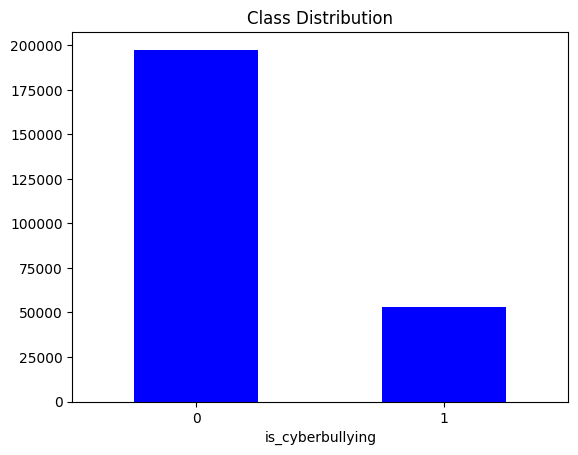

In [23]:
df["is_cyberbullying"].value_counts().plot(kind="bar", color='blue')
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()